# Good Vibes: The Probability of Earthquake Magnitude and Death
*A Milestone Report for the Introduction to Data Science Project*  
  
**Team Fugacity Members**  
Paul Mundt, u0932146  
Katie Jones, u0541901  

## Data Collection and Cleaning

The main source of data for the regressions comes from the Earthquake Impact Database on earthquake-report.com. For the analysis, we are analyzing data from 2017-2020. The data from 2020 is partial, and includes information that was availible on Wednesday, March 18th. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [3]:
#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Intensity (MMI / JMA)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Intensity (MMI / JMA)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Intensity (MMI / JMA)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Intensity (MMI)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

In [4]:
#Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020])
earthquake_data = earthquake_data.reset_index()

In [5]:
earthquake_data

,index,Date (UTC),Country,Region,Magnitude,Lat,Long,Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,0.0,0.0,30.0,0.194401,0.0,0.0
1,1,1/3/2017,India,Tripura,5.5,0.00,0.00,3.0,49.0,600.0,1.668774,1456.0,166.0
2,2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,0.0,0.0,0.0,0.752967,500.0,0.0
3,3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0
4,4,1/6/2017,Iran,Fars,5.1,0.00,0.00,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,75,3/13/2020,India,Kerala,2.8,9.79,76.88,0.0,0.0,0.0,0.038254,10.0,0.0
978,76,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,0.0,0.0,0.0,0.007925,2.0,0.0
979,77,3/14/2020,Iran,Qom,4.0,34.56,50.72,0.0,0.0,0.0,0.038254,10.0,0.0
980,78,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,0.0,2.0,0.0,0.235972,20.0,1.0


## Data Exploration

Exploring the data through graphs before applying an analysis.

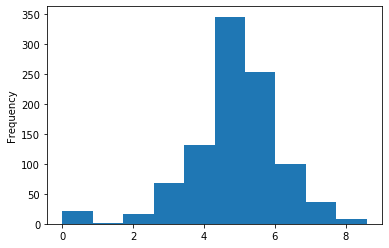

In [6]:
earthquake_data["Magnitude"].plot.hist()

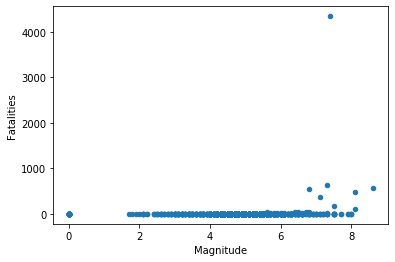

In [12]:
earthquake_data.plot.scatter("Magnitude", "Fatalities")

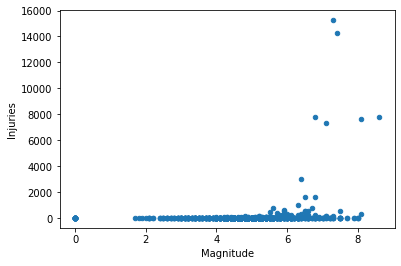

In [13]:
earthquake_data.plot.scatter("Magnitude", "Injuries")

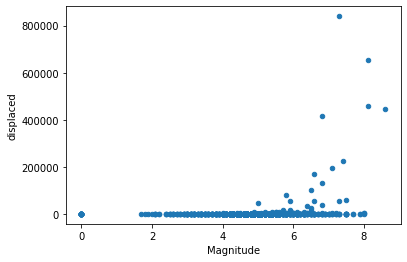

In [14]:
earthquake_data.plot.scatter("Magnitude", "displaced")

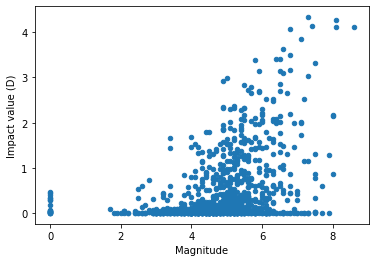

In [15]:
earthquake_data.plot.scatter("Magnitude", "Impact value (D)")

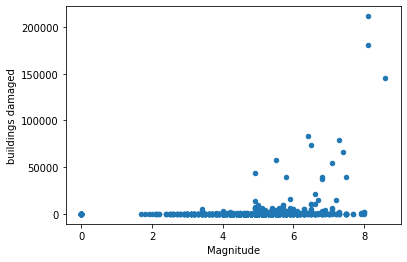

In [16]:
earthquake_data.plot.scatter("Magnitude", "buildings damaged")

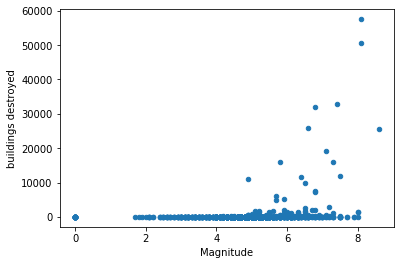

In [17]:
earthquake_data.plot.scatter("Magnitude", "buildings destroyed")

We noticed several things about the data from the graphs above.  

First of all, the data points with a magnitude of zero could skew any analysis, since they indicate impact without an earthquake occuring.  
Second, many of the distributions seem to follow nonlinear and bell-like relationships. This makes us believe there is a factor(s) other than magnitude that affect the relationships. Additionally, the logrithmic behavior of magnitude might be affecting the linearity of the relationship. 

## Regression Analysis
Below, several regression analysis have been performed to see if meaningful relationships between magnitude and the impact factors can be determined. 